In [6]:
# --- Standard libraries
import pickle as pkl
#import numpy as np
import heapq as hq
from icecream import ic
# --- PyTorch
import torch
from torch_geometric.data import Batch
# --- RDKit
from rdkit import Chem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Bokeh
from bokeh.io import output_notebook, show, export_svg
from bokeh.layouts import row
output_notebook()
# --- Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance, spearmanr
# --- Modules from local files
from GNN_atom import GNN
from utils import bokeh_spectra, calculate_rse

Loading BokehJS ...

In [7]:
def pred_spec(model, index, test_dataset):
    # --- Set the model to evaluation mode
    model.eval()

    # --- Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])
    #print(batch.atom_num)

    # --- Pass the graph through the model
    with torch.no_grad():
        pred = model(batch)
    
    # ---  the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.spectrum.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum, true_spectrum

### Coronene

#### Set model parameters

In [8]:
num_tasks = 200
num_layers = 3
emb_dim = 15
in_channels = [int(emb_dim), 256, 128]
out_channels = [256, 128, 64]
gnn_type = 'gcn'
heads = int(1)
drop_ratio = 0.0
graph_pooling = 'mean'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'model_gnn_atom_test.pt'

#### Load the saved model

In [9]:
# --- Load the saved model
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
model.load_state_dict(torch.load("ML_models/" + model_name, map_location='cpu'))

<All keys matched successfully>

#### Load the test data

In [10]:
test_dataset = torch.load("./processed/atom_test_dataset.pt")
print(f'Length of test dataset: {len(test_dataset)}')

Length of test dataset: 795


#### Use the model to predict the test data

In [11]:
# --- Create empty dictionary to contain spectra
predict = {}
true = {}

# --- Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = pred_spec(model, index, test_dataset)

# --- Parse spectra into dictionary
model_dict = [predict, true]

name = 'spectra_ml_atom_test.pkl'

with open('spectra_results/' + name, "wb") as file:
    pkl.dump(model_dict, file)

#### View predictions

In [12]:
file = open('spectra_results/' + name, 'rb')
data = pkl.load(file)

predict = data[0]
true = data[1]

#### Perform analysis of predictions

In [13]:
wasser = []
mse = []
rse = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(predict[x], true[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(predict[x], true[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(predict[x], true[x])
    rse.append(rse_temp)

print(f"Average Wasserstein distance = {sum(wasser) / len(wasser)}")
print(f"Average MSE = {sum(mse) / len(mse)}")
print(f'Average RSE = {sum(rse) / len(rse)}')

Average Wasserstein distance = 0.06313095110919434
Average MSE = 0.030546440060587574
Average RSE = 0.16831457789226548


In [14]:
rank_rse = hq.nsmallest(795, rse)

rank_graph = []

for x in range(795):
    rank_idx = rse.index(rank_rse[x])
    rank_graph.append(rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

The 5 best RSE values are:
RSE = 0.057, graph number = 622
RSE = 0.074, graph number = 467
RSE = 0.074, graph number = 364
RSE = 0.077, graph number = 453
RSE = 0.078, graph number = 295

The 5 worst RSE values are:
RSE = 0.437, graph number = 607
RSE = 0.434, graph number = 303
RSE = 0.432, graph number = 522
RSE = 0.422, graph number = 169
RSE = 0.417, graph number = 43


#### View and compare predictions

In [31]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(predict[rank_graph[0]], true[rank_graph[0]])
p2 = bokeh_spectra(predict[rank_graph[1]], true[rank_graph[1]])
p3 = bokeh_spectra(predict[rank_graph[2]], true[rank_graph[2]])
p = row(p1, p2, p3)
show(p)

In [32]:
# --- Plot worst spectra prediction
p1 = bokeh_spectra(predict[rank_graph[0]], true[rank_graph[0]])
p2 = bokeh_spectra(predict[rank_graph[1]], true[rank_graph[1]])
p3 = bokeh_spectra(predict[rank_graph[2]], true[rank_graph[2]])
p = row(p1, p2, p3)
show(p)

In [222]:
graph = rank_graph[-5]
p = bokeh_spectra(predict[graph], true[graph])
show(p)

In [223]:
print(test_dataset[graph].atom_num)
print(test_dataset[graph].neighbors)

tensor([27])
[25, 28, 29]


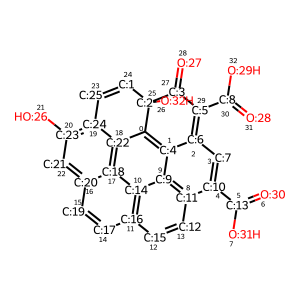

In [224]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.6
mol = Chem.MolFromSmiles(test_dataset[graph].smiles)
mol

In [215]:
from rdkit.Chem import Fragments
from rdkit.Chem.FragmentMatcher import FragmentMatcher

fg = Chem.MolFromSmarts('[CX3](=[OX1])O')
fg = Chem.MolFromSmarts('[CX2][OX2H]')
#fg = Chem.MolFromSmarts('[CX3C](=O)')
#fg = Chem.MolFromSmarts('[CX3H1](=O)')

smart = mol.GetSubstructMatches(fg)

print(smart)

()


In [228]:
for atom in mol.GetAtoms():
    fg = Chem.MolFromSmarts('[CX3](=[OX1])O')
    match = mol.GetSubstructMatches(fg)
    for x in match:
        if atom.GetIdx() in x:
            print('true')
        else:
            print('false')

false
false
false
false
false
false
false
false
false
false
true
false
true
false
true
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
true
false
true
false
true


In [193]:
co = 0
cooh = 0
epox = 0
ald = 0
for i in range(len(test_dataset)):
    mol = Chem.MolFromSmiles(test_dataset[i].smiles)
    # Alcohol
    co_frag = Chem.MolFromSmarts('[#6][OX2H]')
    match = mol.GetSubstructMatches(co_frag)
    for x in match:
        if test_dataset[i].atom_num in x:
            co += 1
    # Carboxylic acid
    cooh_frag = Chem.MolFromSmarts('[CX3](=[OX1])O')
    match = mol.GetSubstructMatches(cooh_frag)
    for x in match:
        if test_dataset[i].atom_num in x:
            cooh += 1
    # Epoxide
    epox_frag = Chem.MolFromSmarts('[#6]-[O]-[#6]')
    match = mol.GetSubstructMatches(epox_frag)
    for x in match:
        if test_dataset[i].atom_num in x:
            epox += 1
    # Aldehyde
    ald_frag = Chem.MolFromSmarts('[CX3H1](=O)')
    match = mol.GetSubstructMatches(ald_frag)
    for x in match:
        if test_dataset[i].atom_num in x:
            ald += 1

In [194]:
print(co)
print(cooh)
print(epox)
print(ald)

58
15
95
10


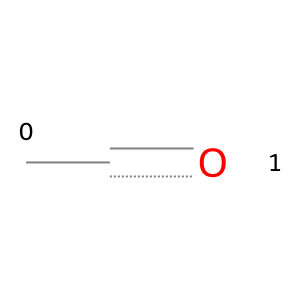

In [218]:
# carboxylic acid
fg = Chem.MolFromSmarts('[CX3](=[OX1])O')
# alcohol
fg = Chem.MolFromSmarts('[CX3][OX2H]')
# ketone
#fg = Chem.MolFromSmarts('[#6][CX3](=O)[#6]')
# aldehyde
#fg = Chem.MolFromSmarts('[CX3H1](=O)[#6]')
# epoxide
#fg = Chem.MolFromSmarts('[#6]-[O]-[#6]')
fg